<a href="https://colab.research.google.com/github/janahendy30/HealthCare-Provider-Fraud-Detection/blob/jana/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: imports & load
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix, classification_report,
                             precision_recall_curve, roc_curve)
import matplotlib.pyplot as plt

# Optional: SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load
df = pd.read_csv("/content/provider_features.csv")
df.head()


,Provider,PotentialFraud,Inpatient_BeneID_nunique,Inpatient_ClaimID_count,Inpatient_InscClaimAmtReimbursed_sum,Inpatient_InscClaimAmtReimbursed_mean,Inpatient_InscClaimAmtReimbursed_max,Inpatient_Total_Procedures_sum,Inpatient_Total_Procedures_mean,Inpatient_Total_Procedures_max,...,Bene_ChronicCond_Heartfailure,Bene_ChronicCond_Cancer,Bene_ChronicCond_Diabetes,Bene_ChronicCond_KidneyDisease,Bene_ChronicCond_ObstrPulmonary,Bene_ChronicCond_Depression,Bene_ChronicCond_IschemicHeart,Bene_ChronicCond_Osteoporasis,Bene_ChronicCond_rheumatoidarthritis,Bene_ChronicCond_stroke
0,PRV51001,No,5.0,5.0,97000.0,19400.000000,42000.0,3.0,0.600000,2.0,...,1.250000,1.791667,1.166667,1.291667,1.625000,1.625000,1.083333,1.750000,1.666667,1.791667
1,PRV51003,Yes,53.0,62.0,573000.0,9241.935484,57000.0,48.0,0.774194,2.0,...,1.401709,1.914530,1.256410,1.555556,1.717949,1.598291,1.153846,1.760684,1.726496,1.923077
2,PRV51004,No,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.405797,1.884058,1.304348,1.659420,1.731884,1.565217,1.289855,1.688406,1.702899,1.884058
3,PRV51005,Yes,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.468687,1.880808,1.365657,1.640404,1.787879,1.628283,1.298990,1.713131,1.743434,1.921212
4,PRV51007,No,3.0,3.0,19000.0,6333.333333,10000.0,1.0,0.333333,1.0,...,1.482759,1.896552,1.379310,1.706897,1.793103,1.637931,1.310345,1.706897,1.724138,1.844828


In [ ]:
df.columns


Index(['Provider', 'PotentialFraud', 'Inpatient_BeneID_nunique',
       'Inpatient_ClaimID_count', 'Inpatient_InscClaimAmtReimbursed_sum',
       'Inpatient_InscClaimAmtReimbursed_mean',
       'Inpatient_InscClaimAmtReimbursed_max',
       'Inpatient_Total_Procedures_sum', 'Inpatient_Total_Procedures_mean',
       'Inpatient_Total_Procedures_max',
       'Inpatient_AttendingPhysician_nunique',
       'Inpatient_OperatingPhysician_nunique', 'Outpatient_BeneID_nunique',
       'Outpatient_ClaimID_count', 'Outpatient_InscClaimAmtReimbursed_sum',
       'Outpatient_InscClaimAmtReimbursed_mean',
       'Outpatient_InscClaimAmtReimbursed_max',
       'Outpatient_Total_Procedures_sum', 'Outpatient_Total_Procedures_mean',
       'Outpatient_Total_Procedures_max',
       'Outpatient_AttendingPhysician_nunique',
       'Outpatient_OperatingPhysician_nunique', 'Bene_Age',
       'Bene_ChronicCond_Alzheimer', 'Bene_ChronicCond_Heartfailure',
       'Bene_ChronicCond_Cancer', 'Bene_ChronicCond_Dia

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Assuming df is your DataFrame, and 'PotentialFraud' is the target column
target_col = 'PotentialFraud'
x = df.drop(columns=[target_col, 'Provider'])  # Drop target and identifier column
y = df[target_col]  # Define the target variable

# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric and categorical columns
numeric_cols = x.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = x.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

# Create a pipeline with SMOTE and a classifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),  # Oversample the minority class (fraudulent cases)
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(x_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Inpatient_BeneID_nunique',
                                                   'Inpatient_ClaimID_count',
                                                   'Inpatient_InscClaimAmtReimbursed_sum',
                                                   'Inpatient_InscClaimAmtReimbursed_mean',
                                                   'Inpatient_InscClaimAmtReimbursed_max',
                                                   'Inpatient_Total...
                                                   'Bene_ChronicCond_Depression',
                                                   'Bene_ChronicCond_IschemicHeart',
                                                   'Bene_ChronicCond_Osteoporasis', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('smote', SMOTE(sampling_strategy='minority')),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
print(y.unique())


['No' 'Yes']


In [ ]:
# Generate predictions on the test set
y_pred = pipeline.predict(x_test)


In [ ]:
# Convert 'Yes' and 'No' to numeric labels (1 for 'Yes', 0 for 'No')
y_test_numeric = pd.Series(y_test).map({'Yes': 1, 'No': 0})
y_pred_numeric = pd.Series(y_pred).map({'Yes': 1, 'No': 0})


In [ ]:
# Evaluate the model using metrics
precision = precision_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"Precision: {precision}")

recall = recall_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"Recall: {recall}")

f1 = f1_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"F1 Score: {f1}")

# For PR AUC and ROC AUC, ensure to use probabilities for the positive class ('Yes')
y_prob = pipeline.predict_proba(x_test)[:, 1]  # Probabilities for the positive class ('Yes')

pr_auc = average_precision_score(y_test_numeric, y_prob)
print(f"PR AUC: {pr_auc}")

roc_auc = roc_auc_score(y_test_numeric, y_prob)
print(f"ROC AUC: {roc_auc}")


Precision: 0.5193798449612403
Recall: 0.638095238095238
F1 Score: 0.5726495726495726
PR AUC: 0.5967896589008771
ROC AUC: 0.9134473850952869


In [ ]:
# Import additional models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Create pipelines for each model with SMOTE
dt_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

log_reg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('classifier', LogisticRegression(random_state=42))
])

rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

gb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

svm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('classifier', SVC(probability=True, random_state=42))
])

# Function to evaluate models using metrics
def evaluate_model(model_pipeline, X_train, y_train, X_test, y_test):
    # Train the model
    model_pipeline.fit(X_train, y_train)

    # Generate predictions
    y_pred = model_pipeline.predict(X_test)

    # Convert y_test and y_pred to numeric format for scoring (Yes=1, No=0)
    y_test_numeric = y_test.map({'Yes': 1, 'No': 0})
    y_pred_numeric = pd.Series(y_pred).map({'Yes': 1, 'No': 0})

    # Calculate performance metrics
    precision = precision_score(y_test_numeric, y_pred_numeric, pos_label=1)
    recall = recall_score(y_test_numeric, y_pred_numeric, pos_label=1)
    f1 = f1_score(y_test_numeric, y_pred_numeric, pos_label=1)

    # For PR AUC and ROC AUC, need probabilities for the positive class (fraudulent)
    y_prob = model_pipeline.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test_numeric, y_prob)
    roc_auc = roc_auc_score(y_test_numeric, y_prob)

    # Print results
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"PR AUC: {pr_auc}")
    print(f"ROC AUC: {roc_auc}")

# Evaluate each model
print("Decision Tree Results:")
evaluate_model(dt_pipeline, X_train, y_train, X_test, y_test)

print("\nLogistic Regression Results:")
evaluate_model(log_reg_pipeline, X_train, y_train, X_test, y_test)

print("\nRandom Forest Results:")
evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test)

print("\nGradient Boosting Results:")
evaluate_model(gb_pipeline, X_train, y_train, X_test, y_test)

print("\nSupport Vector Machine Results:")
evaluate_model(svm_pipeline, X_train, y_train, X_test, y_test)


Decision Tree Results:
Precision: 0.4339622641509434
Recall: 0.6831683168316832
F1 Score: 0.5307692307692308
PR AUC: 0.32604413093630363
ROC AUC: 0.7957125987828141

Logistic Regression Results:
Precision: 0.41013824884792627
Recall: 0.8811881188118812
F1 Score: 0.559748427672956
PR AUC: 0.7524809744366011
ROC AUC: 0.9580242427912515

Random Forest Results:
Precision: 0.5347222222222222
Recall: 0.7623762376237624
F1 Score: 0.6285714285714286
PR AUC: 0.6898081358801995
ROC AUC: 0.9478002846156175

Gradient Boosting Results:
Precision: 0.44751381215469616
Recall: 0.801980198019802
F1 Score: 0.574468085106383
PR AUC: 0.708434140222174
ROC AUC: 0.9442274502679627

Support Vector Machine Results:
Precision: 0.3870967741935484
Recall: 0.8316831683168316
F1 Score: 0.5283018867924528
PR AUC: 0.5208858108688232
ROC AUC: 0.9292296202097274


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0
Recall: 0.0
F1 Score: 0.0
PR AUC: 0.10116359383958401
ROC AUC: 0.5090935699074495


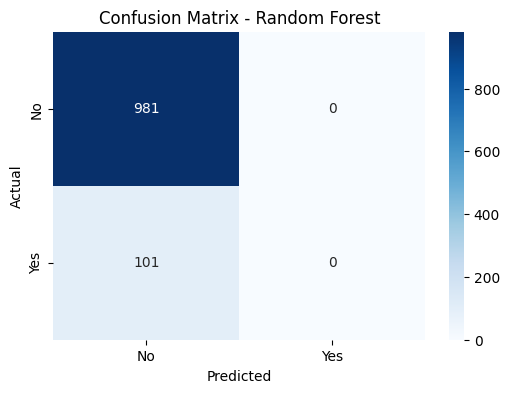

In [ ]:
# Convert 'Yes' and 'No' to numeric labels (1 for 'Yes', 0 for 'No')
y_test_numeric = y_test.map({'Yes': 1, 'No': 0})
y_pred_numeric = pd.Series(y_pred).map({'Yes': 1, 'No': 0})

# Now calculate the metrics with the converted labels
precision = precision_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"Precision: {precision}")

recall = recall_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"Recall: {recall}")

f1 = f1_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"F1 Score: {f1}")

# For PR AUC and ROC AUC, ensure to use probabilities for the positive class ('Yes')
y_prob = model.predict_proba(x_test)[:, 1]  # Probabilities for the positive class ('Yes')

pr_auc = average_precision_score(y_test_numeric, y_prob)
print(f"PR AUC: {pr_auc}")

roc_auc = roc_auc_score(y_test_numeric, y_prob)
print(f"ROC AUC: {roc_auc}")

# Optionally, display confusion matrix and plots
cm = confusion_matrix(y_test_numeric, y_pred_numeric)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [1]:
# my hypothesis i believe that random forest is the better model

Logistic Regression Results:


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0
Recall: 0.0
F1 Score: 0.0
PR AUC: 0.10147263870262259
ROC AUC: 0.5237331072556797


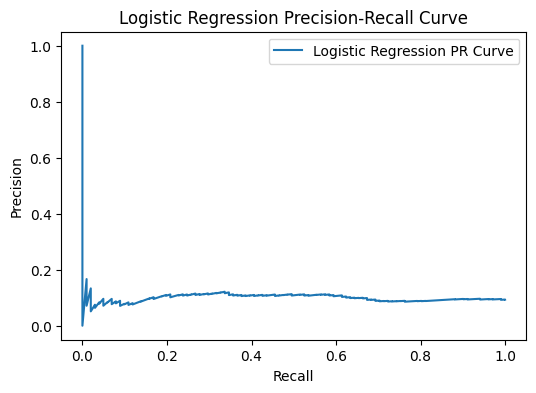

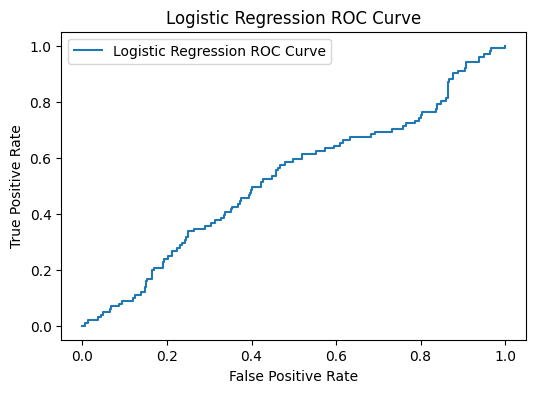

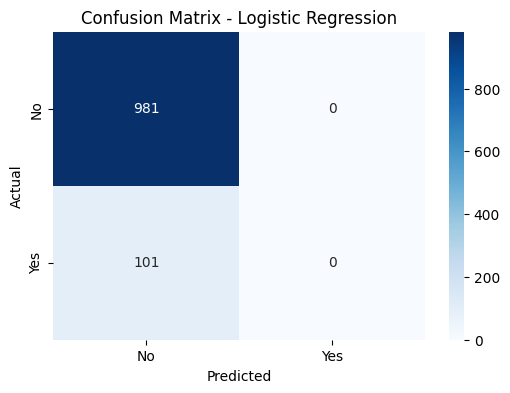

Random Forest Results:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0
Recall: 0.0
F1 Score: 0.0
PR AUC: 0.08982083985260644
ROC AUC: 0.4927483574045478


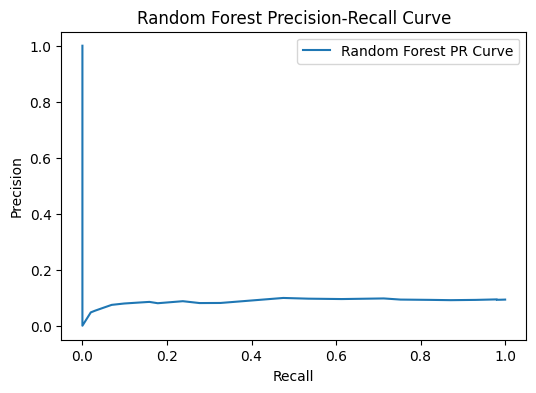

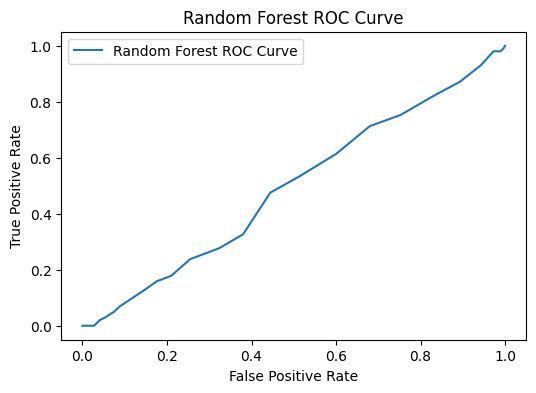

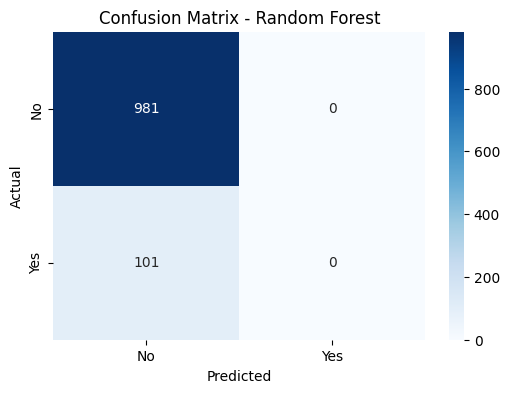

Gradient Boosting Results:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
PR AUC: 0.10014554108615481
ROC AUC: 0.5294456051109698


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


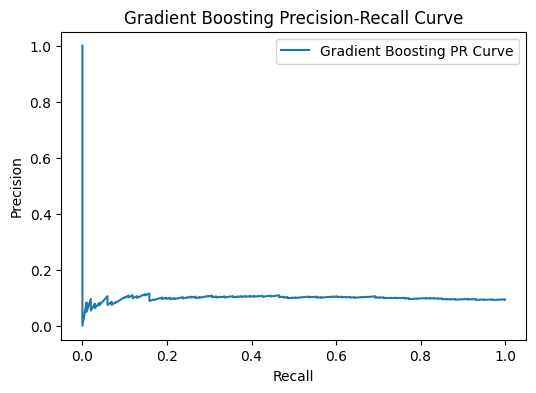

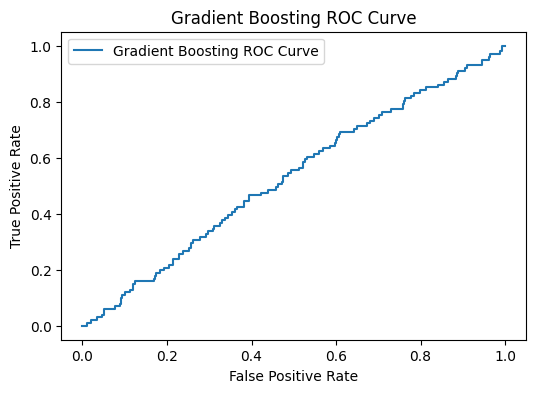

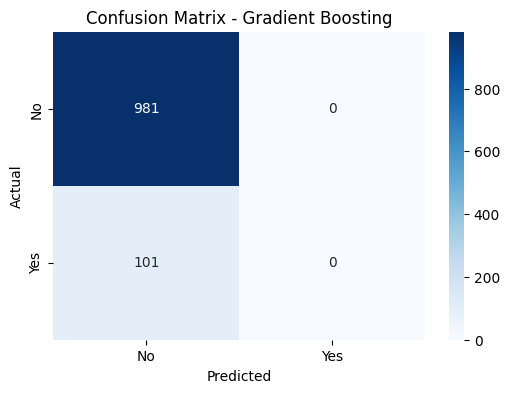

SVM Results:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0
Recall: 0.0
F1 Score: 0.0
PR AUC: 0.09637425559140778
ROC AUC: 0.5125402448501731


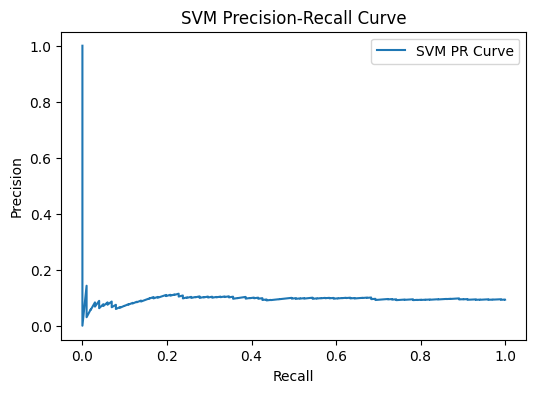

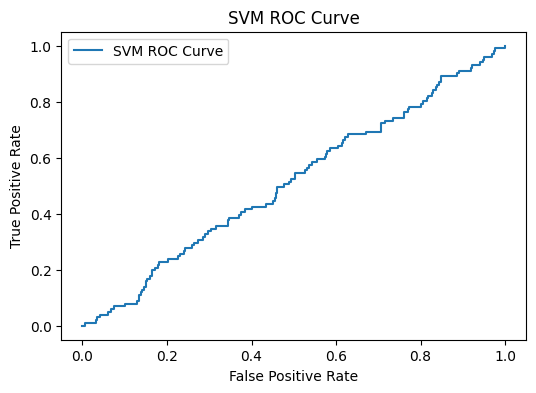

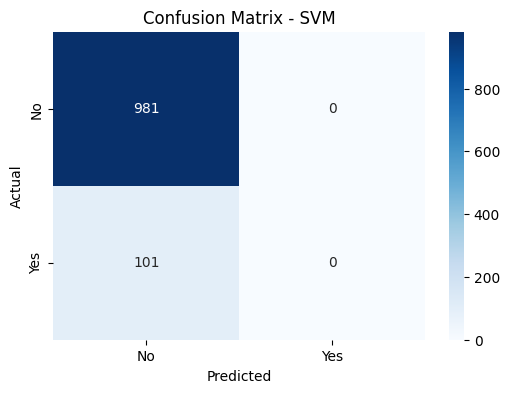

                 Model  Precision  Recall  F1 Score    PR AUC   ROC AUC
0  Logistic Regression        0.0     0.0       0.0  0.101473  0.523733
1        Random Forest        0.0     0.0       0.0  0.089821  0.492748
2    Gradient Boosting        0.0     0.0       0.0  0.100146  0.529446
3                  SVM        0.0     0.0       0.0  0.096374  0.512540


In [ ]:
# Define all models for comparison
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True)
}

# Store results for comparison
results = []

# Loop through all models
for model_name, model in models.items():
    print(f"{model_name} Results:")

    # Fit the model
    model.fit(x_train, y_train)

    # Generate predictions on the test set
    y_pred = model.predict(x_test)

    # Convert predictions and true values to numeric
    y_test_numeric = pd.Series(y_test).map({'Yes': 1, 'No': 0})
    y_pred_numeric = pd.Series(y_pred).map({'Yes': 1, 'No': 0})

    # Calculate metrics
    precision = precision_score(y_test_numeric, y_pred_numeric, pos_label=1)
    recall = recall_score(y_test_numeric, y_pred_numeric, pos_label=1)
    f1 = f1_score(y_test_numeric, y_pred_numeric, pos_label=1)
    pr_auc = average_precision_score(y_test_numeric, model.predict_proba(x_test)[:, 1])
    roc_auc = roc_auc_score(y_test_numeric, model.predict_proba(x_test)[:, 1])

    # Store the metrics
    results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'PR AUC': pr_auc,
        'ROC AUC': roc_auc
    })

    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"PR AUC: {pr_auc}")
    print(f"ROC AUC: {roc_auc}")

    # Plot Precision-Recall curve
    plt.figure(figsize=(6, 4))
    precision_vals, recall_vals, _ = precision_recall_curve(y_test_numeric, model.predict_proba(x_test)[:, 1])
    plt.plot(recall_vals, precision_vals, label=f'{model_name} PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(6, 4))
    fpr, tpr, _ = roc_curve(y_test_numeric, model.predict_proba(x_test)[:, 1])
    plt.plot(fpr, tpr, label=f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test_numeric, y_pred_numeric)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Display model comparison results
comparison_df = pd.DataFrame(results)
print(comparison_df)


In [2]:
#based on the results my hypothesis was wrong since logistic regression has the hughest PR AUC AND ROC AUC